In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import import_data
import preprocessing
import feature_extraction
import dimension_reduction
import classification
import matplotlib 
import os


test_size = 0.2
random_state = 104

[nltk_data] Downloading package wordnet to /home/makus/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/makus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
os.chdir('/home/makus/Documents/Semester_7_WIN2022/Bachelorarbeit/bachelor-thesis/img/')

# load data

In [3]:
trec = import_data.create_trec_from_csv("/home/makus/Documents/Semester_7_WIN2022/Bachelorarbeit/ba_code/datasets/TREC_2007_processed_data.csv")
trec

,text,label
0,"Generic Cialis, branded quality@ the00@speedy....",1
1,Typo in /debian/READMEdebian-mirrors@lists.deb...,0
2,"authentic viagra<the00@plg.uwaterloo.ca>""Sheil...",1
3,"Nice talking with yaopt4@speedy.uwaterloo.ca""S...",1
4,or trembling; stomach cramps; trouble in sleep...,1
...,...,...
75414,the reply for your request for a job place [le...,1
75415,the reply for your request for a job place [le...,1
75416,"Re: [R] Me again, about the horrible documenta...",0
75417,Re: [R] RODBC problem<r-help@stat.math.ethz.ch...,0


# feature extraction + dimension reduction

In [4]:
y = trec['label']
mails = trec['text']

tfidf_mails = feature_extraction.tfidf_vectorize(mails)
sparse_mails = dimension_reduction.sparse_random_projection(tfidf_mails)
ipca_mails = dimension_reduction.ipca(sparse_mails, 100)
X = ipca_mails
del mails, tfidf_mails, sparse_mails, ipca_mails, trec

X.shape


It took 53.90974215800088 second(s) to finish TF-IDF feature extraction.
It took 44.66385461999744 second(s) to finish dimension reduction with Sparse Random Projection.
It took 623.7004148210035 second(s) to finish dimension reduction with IPCA.


(75261, 100)

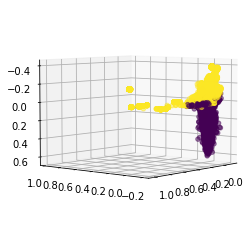

In [5]:
xs = X[:,0]
ys = X[:,1]
zs = X[:,2]
colors = y

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter3D(xs,ys,zs,c=colors,alpha=0.5)
ax.view_init(-175,140)
plt.savefig('trec_graph.pdf')
plt.show()

# Reference SVM classification

In [6]:
reference_report, X_test, y_test, y_pred = classification.svm(X,y,test_size, random_state)

reference_report

SVM model fitted in 109.46118951799872 second(s)
SVM predicted the testset in 15.90981170500163 second(s)


,0,1,accuracy,macro avg,weighted avg
precision,0.987585,0.969765,0.975487,0.978675,0.975781
recall,0.939197,0.993983,0.975487,0.966590,0.975487
f1-score,0.962784,0.981725,0.975487,0.972254,0.975330
support,5082.000000,9971.000000,0.975487,15053.000000,15053.000000


this is our reference svm for the comparison

Got 369 classificaton mistakes


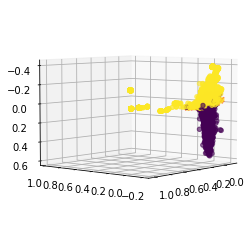

In [7]:
x_wrong = X_test[y_test != y_pred]
print("Got %d classificaton mistakes" % len(x_wrong))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter3D(X_test[:,0], X_test[:,1], X_test[:,2],c=y_pred, marker="o")
ax.scatter(x_wrong[:,0], x_wrong[:,1], x_wrong[:,2], color='red', marker="x")
ax.view_init(-175,140)
plt.show()

# K-Means + Elbow plot

Now we create our elbow graph. A cluster count above 25 has not much sense.

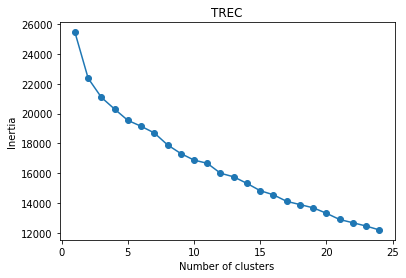

In [18]:
max_cluster = 25
inertias = classification.elbow_inertias_list(X,max_cluster)

plt.figure()
plt.plot(range(1,max_cluster), inertias, marker='o')
plt.title('TREC')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.savefig('trec_elbow_high_dim.pdf')
plt.show() 

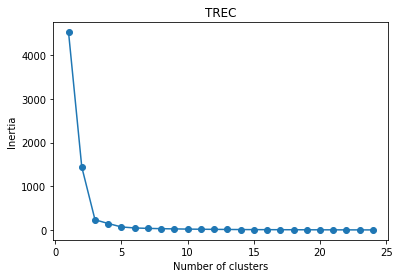

In [19]:
max_cluster = 25
inertias = classification.elbow_inertias_list(X[:,:2],max_cluster)

plt.figure()
plt.plot(range(1,max_cluster), inertias, marker='o')
plt.title('TREC')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.savefig('trec_elbow_two_dim.pdf')
plt.show() 

# SVM and K-Means merging hypothesis

Now we test our hypothesis, wether replacing the original labels with k-means generated labels can improve a svm classification

In [10]:
report, X_test, y_test, y_pred = classification.svm_merging_hypothesis(2,X,y)
report

It took 53.72084788799839 second(s) to search the best k-means clustering for merging hypothesis
It took 55.28767910299939 second(s) to complete the svm classification combined with k-means - merging hypothesis


,0,1,accuracy,macro avg,weighted avg
precision,0.351866,1.000000,0.378131,0.675933,0.781185
recall,1.000000,0.061177,0.378131,0.530589,0.378131
f1-score,0.520563,0.115301,0.378131,0.317932,0.252120
support,5082.000000,9971.000000,0.378131,15053.000000,15053.000000


k-means with the original cluster count does not improve the classification

Got 9361 classificaton mistakes


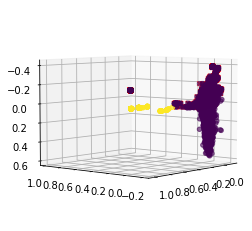

In [11]:
x_wrong = X_test[y_test != y_pred]
print("Got %d classificaton mistakes" % len(x_wrong))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter3D(X_test[:,0], X_test[:,1], X_test[:,2],c=y_pred, marker="o")
ax.scatter(x_wrong[:,0], x_wrong[:,1], x_wrong[:,2], color='red', marker="x")
ax.view_init(-175,140)
plt.show()

Now we estimate a good cluster count based on the graph

In [12]:
report, X_test, y_test, y_pred = classification.svm_merging_hypothesis(3,X,y)
report

It took 68.82336932999897 second(s) to search the best k-means clustering for merging hypothesis
It took 70.04967159799708 second(s) to complete the svm classification combined with k-means - merging hypothesis


,0,1,accuracy,macro avg,weighted avg
precision,0.351866,1.000000,0.378131,0.675933,0.781185
recall,1.000000,0.061177,0.378131,0.530589,0.378131
f1-score,0.520563,0.115301,0.378131,0.317932,0.252120
support,5082.000000,9971.000000,0.378131,15053.000000,15053.000000


Got 9361 classificaton mistakes


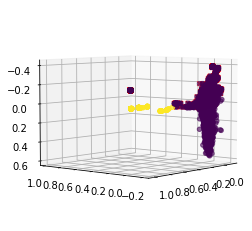

In [13]:
x_wrong = X_test[y_test != y_pred]
print("Got %d classificaton mistakes" % len(x_wrong))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter3D(X_test[:,0], X_test[:,1], X_test[:,2],c=y_pred, marker="o")
ax.scatter(x_wrong[:,0], x_wrong[:,1], x_wrong[:,2], color='red', marker="x")
ax.view_init(-175,140)
plt.show()

For increasing the number of clusters, the classification is getting worse.
The classification results are worse than the normal SVM
 
-> Merging is not a good approach

# Adding K-means clustering as new feature

we add now the k-means clustering result as a new column in our dataset and then classify the data with a svm. -> Test this approach with cluster count between 2 and 25

In [14]:
reference_report

,0,1,accuracy,macro avg,weighted avg
precision,0.987585,0.969765,0.975487,0.978675,0.975781
recall,0.939197,0.993983,0.975487,0.966590,0.975487
f1-score,0.962784,0.981725,0.975487,0.972254,0.975330
support,5082.000000,9971.000000,0.975487,15053.000000,15053.000000


In [15]:
report = classification.k_means_cluster_search(X,y,25)
report

,Number_of_clusters,Accuracy,F_one_Score,Time
0,2.0,0.975487,0.962791,112.967355
1,3.0,0.975553,0.962896,125.461196
2,4.0,0.958081,0.936577,213.054474
3,5.0,0.957085,0.935154,213.819596
4,6.0,0.957019,0.934929,210.509466
5,7.0,0.954428,0.931564,222.609965
6,8.0,0.831396,0.757686,257.266192
7,9.0,0.632432,0.176514,827.252715
8,10.0,0.698731,0.538516,540.410520
9,11.0,0.593835,0.410187,780.832341


Doesn't seems to be a good aproach too.

# Combine both approaches

Add the merging approach as a new feature vector to the dataset and then classify with svm.

In [16]:
report = classification.k_means_cluster_search_merging_hypothesis(X,y,3)
report

It took 116.41315050199773 second(s) to search the best k-means clustering for merging hypothesis


,Accuracy,F_one_Score,Time
0,0.975553,0.962896,259.238877


In [17]:
report = classification.k_means_cluster_search_merging_hypothesis(X,y,4)
report

It took 151.58514847699553 second(s) to search the best k-means clustering for merging hypothesis


,Accuracy,F_one_Score,Time
0,0.97542,0.962687,298.153102


It is very computation heavy even on a small dataset. So even a slightly improve is not worth.